# 📈 Continuous-Time Recurrent Neural Networks

## Neural ODEs for Dynamical Systems

In this notebook, we implement a **Continuous-Time RNN (CT-RNN)** — a recurrent network whose dynamics are defined by an ODE.

### The CT-RNN Equation

$$\tau \frac{d\mathbf{h}}{dt} = -\mathbf{h} + \phi(\mathbf{W}_{rec}\mathbf{h} + \mathbf{W}_{in}\mathbf{x} + \mathbf{b})$$

### Why Continuous-Time?
1. **Biological plausibility**: Neurons evolve continuously
2. **Arbitrary time steps**: Can interpolate between observations  
3. **Smooth dynamics**: Amenable to analysis
4. **Memory efficient training**: Adjoint method

In [1]:
# Setup
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install -q torch torchdiffeq matplotlib scipy tqdm
    !git clone -q https://github.com/CNNC-Lab/RNNs-tutorial.git
    %cd RNNs-tutorial

# Import from src/
from src import setup_environment, check_dependencies

check_dependencies()
device = setup_environment()

✓ All dependencies installed
✓ Environment ready. Using device: cpu


## Part 1: Load Shared Data

We'll load the preprocessed Lorenz data generated in notebook 00. This ensures consistency across all model comparisons.

In [2]:
# Load shared dataset from notebook 00
from src.data import create_shared_dataloaders
import numpy as np
import torch
import torch.nn as nn

print("Loading shared dataset from notebook 00...")
train_loader, val_loader, test_loader, info = create_shared_dataloaders(
    dataset_path='../data/processed/lorenz_data.npz',
    batch_size=64
)

# Extract normalization params for later denormalization
mean = info['normalization']['mean']
std = info['normalization']['std']
dt = info['dt']
seq_length = info['seq_length']

print(f"\n✓ Data loaded successfully!")
print(f"  Dataset info: {info['train_samples']} train, {info['val_samples']} val, {info['test_samples']} test")
print(f"  Sequence length: {seq_length}, dt: {dt}")
print(f"  Normalization - mean: {mean}, std: {std}")

Loading shared dataset from notebook 00...
✓ Dataset loaded from ../data/processed/lorenz_data.npz
  Train: (14000, 3), Val: (3000, 3), Test: (3000, 3)
  dt=0.01, seq_length=50

✓ Data loaded successfully!
  Dataset info: 13950 train, 2950 val, 2950 test
  Sequence length: 50, dt: 0.01
  Normalization - mean: [-0.76262796 -0.75006465 23.46947626], std: [7.86860479 8.99086565 8.66683304]


**Data Pipeline**: The data was generated in notebook 00 using `src.data.generate_lorenz_trajectory()`, split into train/val/test, normalized, and saved to `data/processed/lorenz_data.npz`. We're now loading that shared dataset to ensure all models train on identical data.

---

---

## Part 2: CT-RNN Implementation

### The Core Dynamics
The CT-RNN cell computes $d\mathbf{h}/dt$ given current state and input.

**Note**: A production-ready implementation is available in `src.models.ContinuousTimeRNN`. We'll use that implementation for this tutorial.

In [3]:
# Import CT-RNN from src.models
from src.models import ContinuousTimeRNN
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Create model with FAST solver (euler instead of default dopri5)
# For this tutorial, euler is ~100x faster and sufficiently accurate
model = ContinuousTimeRNN(
    input_size=3,
    hidden_size=64,
    output_size=3,
    tau=1.0,
    solver='euler'  # Fast! Use 'dopri5' for higher accuracy (but much slower)
).to(device)

# Count parameters
n_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {n_params:,}")

# Test forward pass
sample_x, sample_y = next(iter(train_loader))
sample_x = sample_x.to(device)
out = model(sample_x)
print(f"Input: {sample_x.shape} -> Output: {out.shape}")

print("\n✓ CT-RNN model loaded from src.models")
print(f"  ODE Solver: euler (fast)")
print(f"  See src/models/ctrnn.py for implementation details")

Model parameters: 4,547
Input: torch.Size([64, 50, 3]) -> Output: torch.Size([64, 3])

✓ CT-RNN model loaded from src.models
  ODE Solver: euler (fast)
  See src/models/ctrnn.py for implementation details


The `ContinuousTimeRNN` model includes:
- `CTRNNCell`: Implements the ODE dynamics τ dh/dt = -h + φ(W_rec @ h + W_in @ x + b)
- Integration with `torchdiffeq` for memory-efficient backprop through ODEs
- Flexible ODE solvers (rk4, dopri5, euler, etc.)
- `generate()` method for autonomous trajectory generation

## Part 4: Training

### Learning Algorithm & Parameter Tuning

**Optimization Strategy:**
- **Loss function**: Mean Squared Error (MSE) for one-step prediction
- **Optimizer**: AdamW with weight decay for regularization
- **Learning rate**: 1e-3 with ReduceLROnPlateau scheduler (patience=10, factor=0.5)
- **Gradient clipping**: Norm clipping at 1.0 to prevent exploding gradients in RNNs
- **Early stopping**: Save best model based on validation loss

**Key Hyperparameters:**
- `hidden_size=64`: Network capacity
- `tau=1.0`: Time constant controlling dynamics speed
- `seq_length=50`: Input sequence length for context
- `batch_size=64`: Balance between stability and speed
- `weight_decay=1e-5`: L2 regularization to prevent overfitting

**Training Process:**
The adjoint method (used by `torchdiffeq`) enables memory-efficient backpropagation through ODEs by solving a separate ODE backwards in time for gradients.

In [4]:
# Save initial parameters for later comparison
initial_params = {
    'W_rec': model.cell.W_rec.weight.data.clone().cpu().numpy(),
    'W_in': model.cell.W_in.weight.data.clone().cpu().numpy(),
    'decoder': model.decoder.weight.data.clone().cpu().numpy()
}

print("Initial parameters saved for visualization")

Initial parameters saved for visualization


### Training with src.utils

We'll use the standardized training function from `src.utils` which handles:
- Training loop with gradient clipping
- Learning rate scheduling
- Early stopping
- Model checkpointing

In [5]:
# Train using src.utils.train_model
from src.utils import train_model
import os
import torch

os.makedirs('checkpoints', exist_ok=True)

print("Training CT-RNN...")
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=100,
    lr=1e-3,
    weight_decay=1e-5,
    patience=20,
    device=device,
    verbose=True
)

best_val = min(history['val_loss'])
print(f"\n✓ Training complete!")
print(f"  Best validation loss: {best_val:.6f}")

# Save the trained model (train_model() already restored best weights)
checkpoint_path = 'checkpoints/ctrnn_best.pt'
torch.save(model.state_dict(), checkpoint_path)
print(f"  Model saved to {checkpoint_path}")

Training CT-RNN...


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10: train_loss=0.000023, val_loss=0.000054
Epoch 20: train_loss=0.000014, val_loss=0.000018
Epoch 30: train_loss=0.000016, val_loss=0.000094
Epoch 40: train_loss=0.000007, val_loss=0.000016
Epoch 50: train_loss=0.000005, val_loss=0.000008
Epoch 60: train_loss=0.000011, val_loss=0.000009
Epoch 70: train_loss=0.000000, val_loss=0.000002
Epoch 80: train_loss=0.000003, val_loss=0.000018
Epoch 90: train_loss=0.000001, val_loss=0.000001
Epoch 100: train_loss=0.000000, val_loss=0.000001

✓ Training complete!
  Best validation loss: 0.000001
  Model saved to checkpoints/ctrnn_best.pt


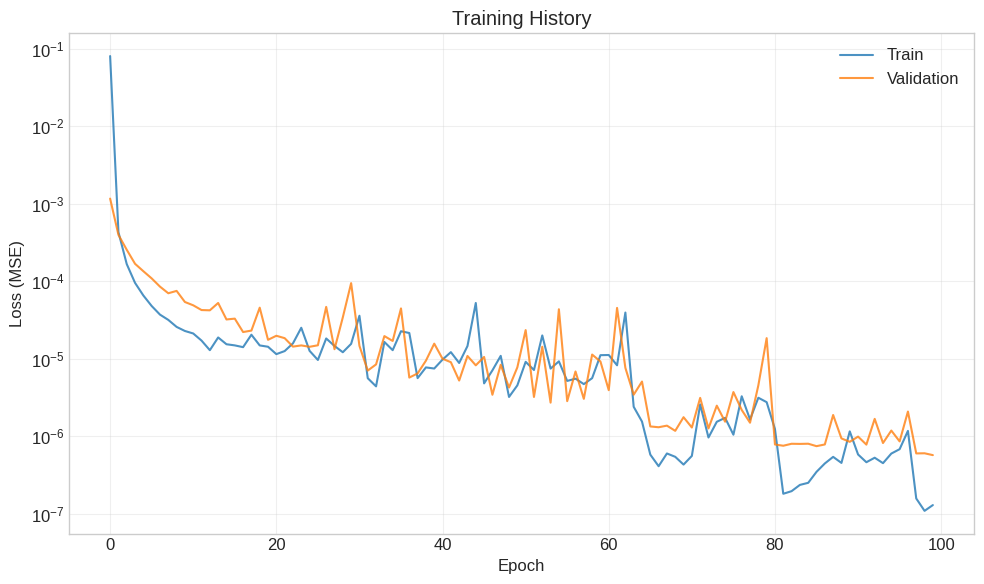

Training Summary:
  Initial train loss: 0.080002
  Final train loss: 0.000000
  Initial val loss: 0.001161
  Best val loss: 0.000001
  Improvement: 100.0%


In [6]:
# Plot training history using src.utils
from src.utils import plot_training_history

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_training_history(history, ax)
plt.tight_layout()
plt.show()

# Print training summary
print(f"Training Summary:")
print(f"  Initial train loss: {history['train_loss'][0]:.6f}")
print(f"  Final train loss: {history['train_loss'][-1]:.6f}")
print(f"  Initial val loss: {history['val_loss'][0]:.6f}")
print(f"  Best val loss: {best_val:.6f}")
print(f"  Improvement: {(1 - best_val/history['val_loss'][0])*100:.1f}%")

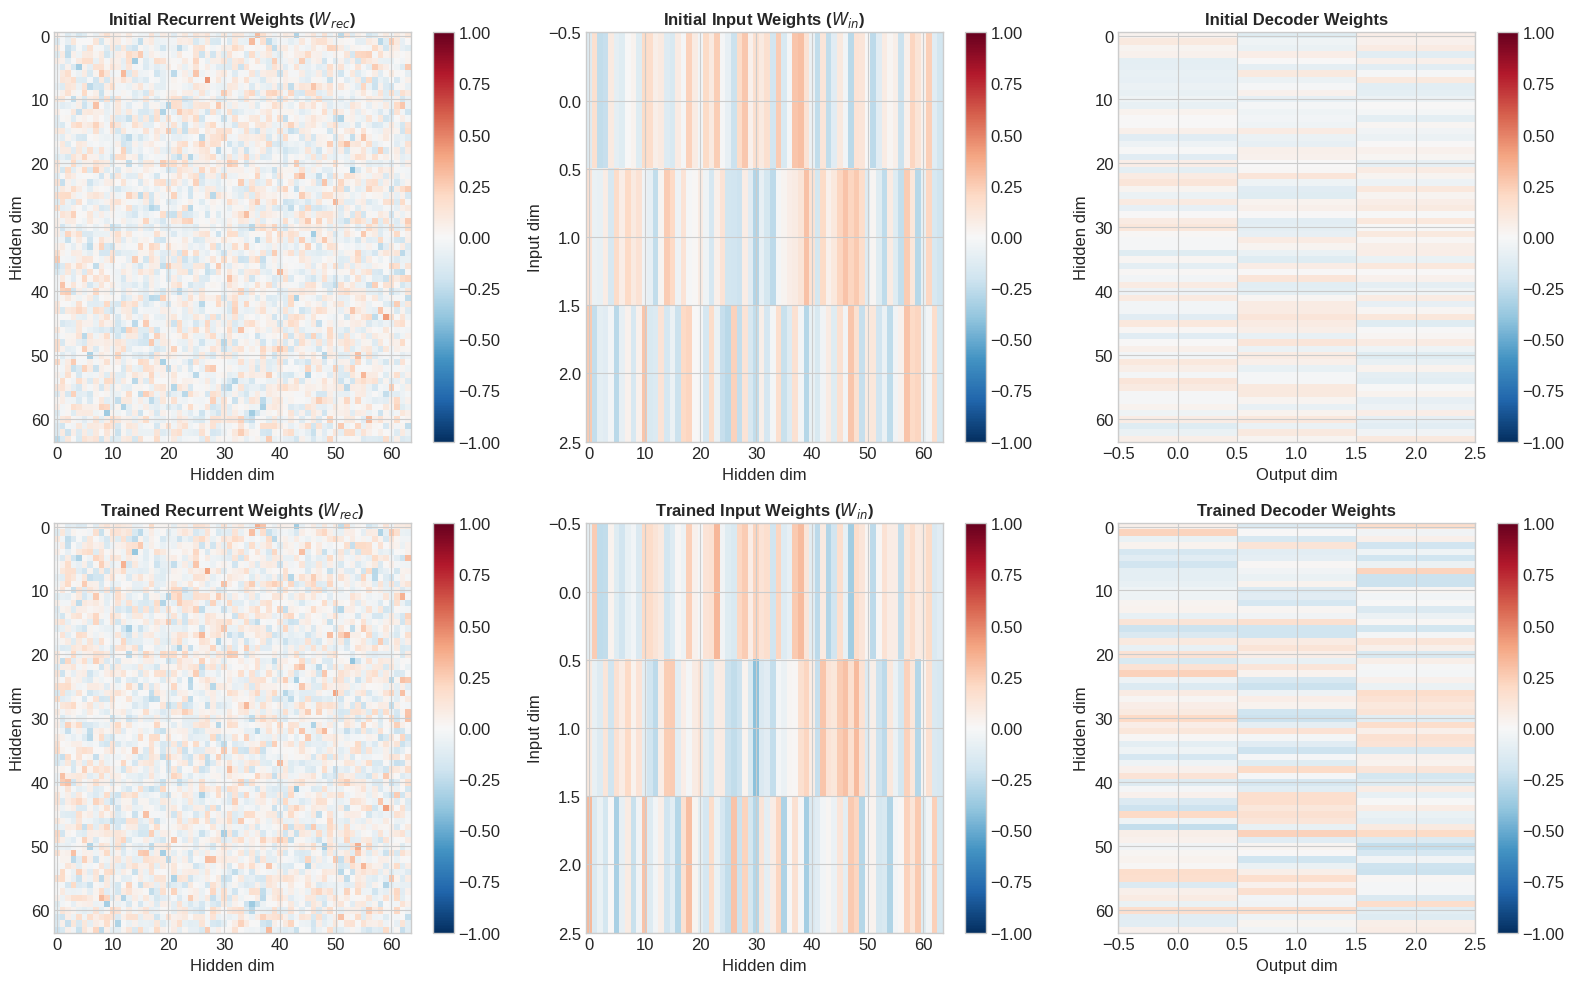

Parameter Change Statistics:

W_rec:
  Mean absolute change: 0.032852
  Max absolute change: 0.158216
  Relative change: 36.14%

W_in:
  Mean absolute change: 0.044506
  Max absolute change: 0.123699
  Relative change: 32.41%

decoder:
  Mean absolute change: 0.064559
  Max absolute change: 0.137360
  Relative change: 102.27%


In [7]:
# Get trained parameters
trained_params = {
    'W_rec': model.cell.W_rec.weight.data.clone().cpu().numpy(),
    'W_in': model.cell.W_in.weight.data.clone().cpu().numpy(),
    'decoder': model.decoder.weight.data.clone().cpu().numpy()
}

# Visualize parameter changes
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Recurrent weights
ax = axes[0, 0]
im = ax.imshow(initial_params['W_rec'], cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
ax.set_title('Initial Recurrent Weights ($W_{rec}$)', fontsize=12, fontweight='bold')
ax.set_xlabel('Hidden dim')
ax.set_ylabel('Hidden dim')
plt.colorbar(im, ax=ax)

ax = axes[1, 0]
im = ax.imshow(trained_params['W_rec'], cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
ax.set_title('Trained Recurrent Weights ($W_{rec}$)', fontsize=12, fontweight='bold')
ax.set_xlabel('Hidden dim')
ax.set_ylabel('Hidden dim')
plt.colorbar(im, ax=ax)

# Input weights
ax = axes[0, 1]
im = ax.imshow(initial_params['W_in'].T, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
ax.set_title('Initial Input Weights ($W_{in}$)', fontsize=12, fontweight='bold')
ax.set_xlabel('Hidden dim')
ax.set_ylabel('Input dim')
plt.colorbar(im, ax=ax)

ax = axes[1, 1]
im = ax.imshow(trained_params['W_in'].T, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
ax.set_title('Trained Input Weights ($W_{in}$)', fontsize=12, fontweight='bold')
ax.set_xlabel('Hidden dim')
ax.set_ylabel('Input dim')
plt.colorbar(im, ax=ax)

# Decoder weights
ax = axes[0, 2]
im = ax.imshow(initial_params['decoder'].T, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
ax.set_title('Initial Decoder Weights', fontsize=12, fontweight='bold')
ax.set_xlabel('Output dim')
ax.set_ylabel('Hidden dim')
plt.colorbar(im, ax=ax)

ax = axes[1, 2]
im = ax.imshow(trained_params['decoder'].T, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
ax.set_title('Trained Decoder Weights', fontsize=12, fontweight='bold')
ax.set_xlabel('Output dim')
ax.set_ylabel('Hidden dim')
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

# Compute parameter change statistics
print("Parameter Change Statistics:")
for name in ['W_rec', 'W_in', 'decoder']:
    delta = trained_params[name] - initial_params[name]
    print(f"\n{name}:")
    print(f"  Mean absolute change: {np.abs(delta).mean():.6f}")
    print(f"  Max absolute change: {np.abs(delta).max():.6f}")
    print(f"  Relative change: {(np.linalg.norm(delta) / np.linalg.norm(initial_params[name]) * 100):.2f}%")

In [8]:
# Load best model and evaluate using src.utils
from src.utils import evaluate, compute_prediction_metrics

model.load_state_dict(torch.load('checkpoints/ctrnn_best.pt'))

# Evaluate on test set
test_loss, preds, targets = evaluate(model, test_loader, nn.MSELoss(), device)

print(f"Test Loss (MSE): {test_loss:.6f}")

# Denormalize predictions
preds_denorm = preds * std + mean
targets_denorm = targets * std + mean

print(f"\nTest Set Predictions:")
print(f"  Predictions shape: {preds_denorm.shape}")

# Compute comprehensive metrics using src.utils
metrics = compute_prediction_metrics(targets_denorm, preds_denorm)

print(f"\nTest Accuracy Metrics:")
print(f"  MSE:  {metrics['mse']:.6f}")
print(f"  RMSE: {metrics['rmse']:.6f}")
print(f"  MAE:  {metrics['mae']:.6f}")
print(f"  R² score: {metrics['r2']:.4f}")
print(f"  Correlation: {metrics['correlation']:.4f}")
print(f"  NRMSE: {metrics['nrmse']*100:.2f}% of signal std")

# Compute per-dimension R² for visualization
per_dim_r2 = []
for i in range(3):
    ss_res = np.sum((targets_denorm[:, i] - preds_denorm[:, i])**2)
    ss_tot = np.sum((targets_denorm[:, i] - targets_denorm[:, i].mean())**2)
    per_dim_r2.append(1 - ss_res / ss_tot)

print(f"\nPer-dimension R²:")
for i, dim in enumerate(['x', 'y', 'z']):
    print(f"  {dim}: {per_dim_r2[i]:.4f}")

Test Loss (MSE): 0.000000

Test Set Predictions:
  Predictions shape: (2950, 3)

Test Accuracy Metrics:
  MSE:  0.000018
  RMSE: 0.004233
  MAE:  0.002238
  R² score: 1.0000
  Correlation: 1.0000
  NRMSE: 0.01% of signal std

Per-dimension R²:
  x: 1.0000
  y: 1.0000
  z: 1.0000


## Part 5: Evaluation & Visualization

### Test Set Performance

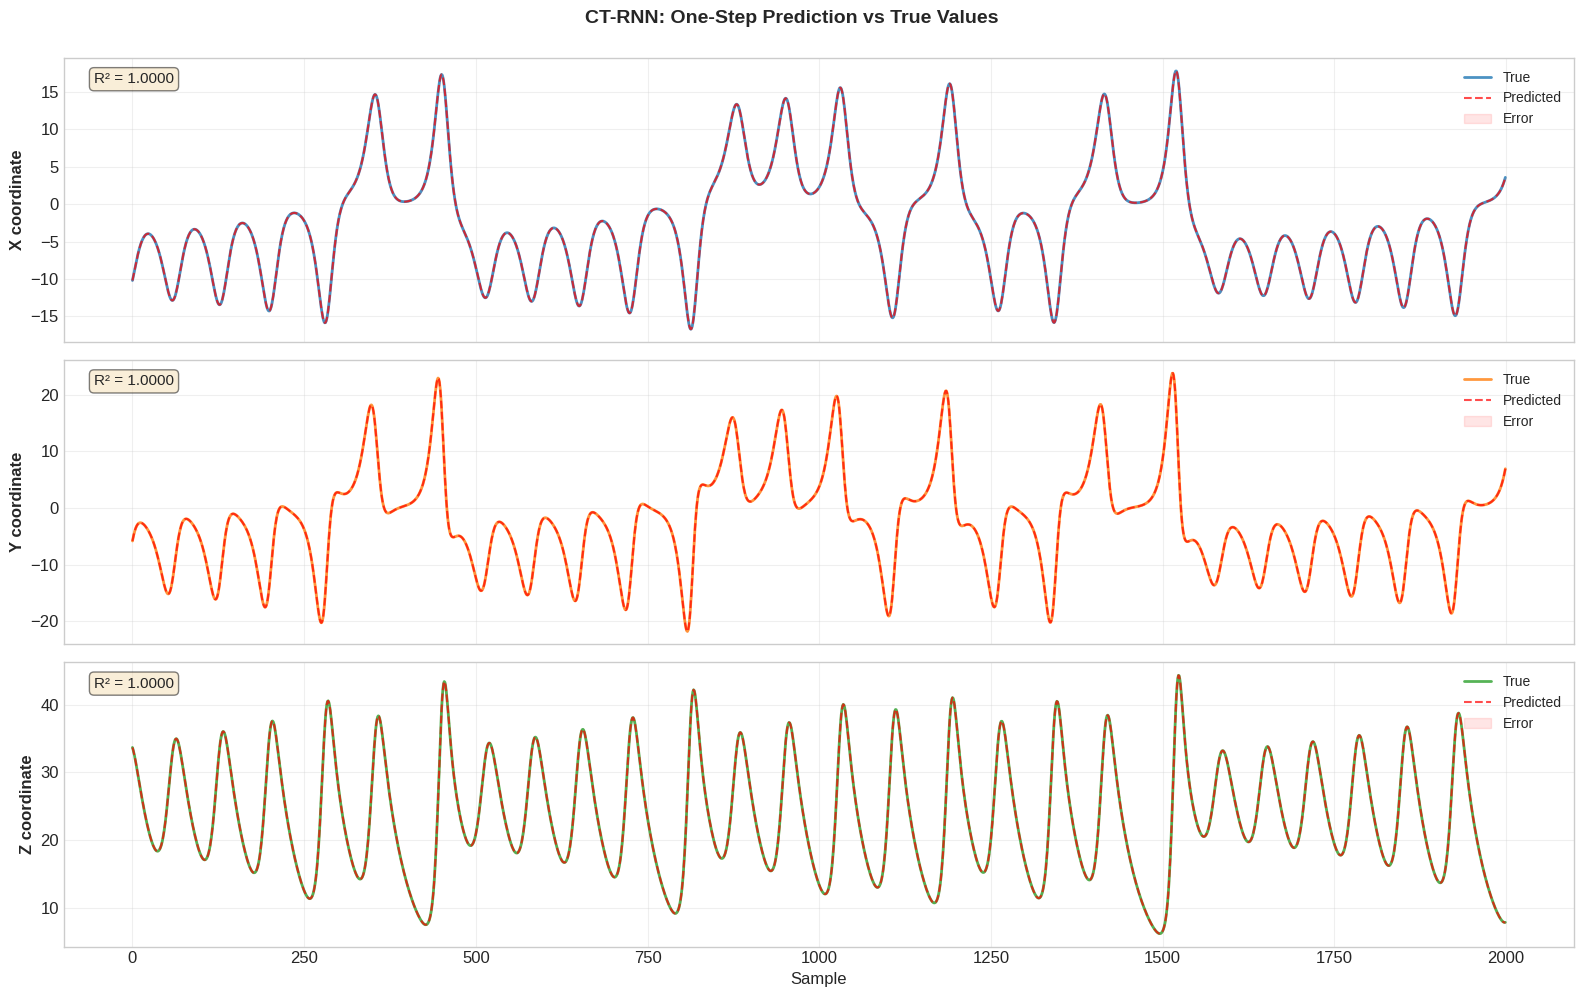

In [9]:
# Visualize predictions using src.utils
from src.utils import plot_prediction_comparison_detailed

fig = plot_prediction_comparison_detailed(
    targets_denorm,
    preds_denorm,
    per_dim_r2,
    n_show=2000,
    title='CT-RNN: One-Step Prediction vs True Values'
)
plt.show()

---

### State-Space Dynamics Visualization

Using PCA to visualize the hidden state trajectories in lower dimensions.

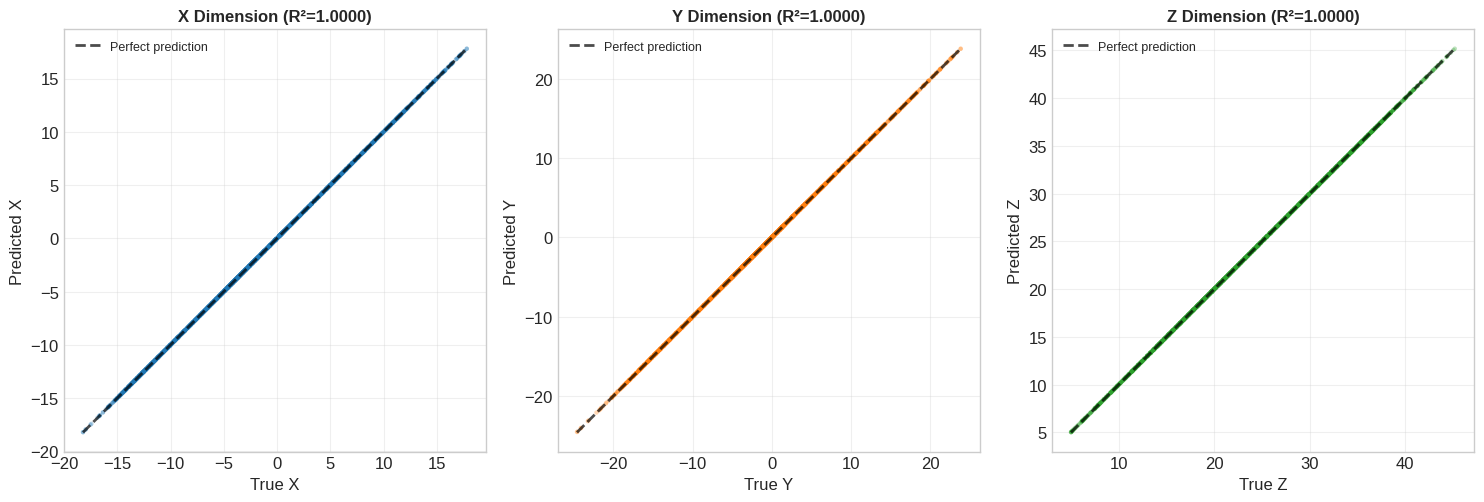

In [10]:
# Scatter plots using src.utils
from src.utils import plot_scatter_prediction

fig = plot_scatter_prediction(targets_denorm, preds_denorm, per_dim_r2)
plt.show()

### State-Space Dynamics Visualization

In [12]:
# Visualize hidden state dynamics using PCA
# Extract hidden states from the model during test set evaluation

model.eval()
all_hidden = []
all_targets = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        hidden, _ = model(x, return_hidden=True)
        # Take the final hidden state for each sequence
        all_hidden.append(hidden[:, -1, :].cpu().numpy())
        all_targets.append(y.numpy())

hidden_states = np.concatenate(all_hidden)
targets = np.concatenate(all_targets)

print(f"Hidden states shape: {hidden_states.shape}")
print(f"Targets shape: {targets.shape}")

# Apply PCA to visualize hidden states in 3D
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
hidden_pca = pca.fit_transform(hidden_states)

print(f"\nPCA explained variance: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

Hidden states shape: (2950, 64)
Targets shape: (2950, 3)

PCA explained variance: [0.52808297 0.32804695 0.1166044 ]
Total variance explained: 97.27%


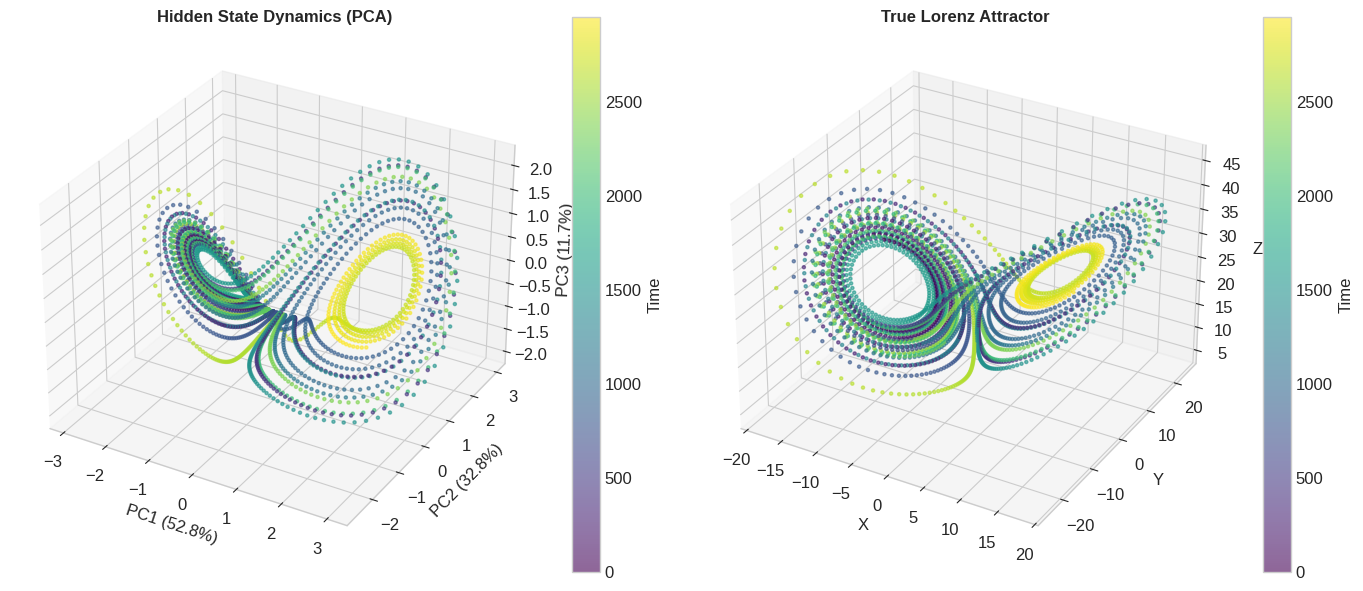


📊 The hidden state dynamics (left) show how the network's internal
   representation evolves while tracking the Lorenz attractor (right).


In [13]:
# Visualize hidden state dynamics in PCA space
fig = plt.figure(figsize=(14, 6))

# PCA projection of hidden states
ax1 = fig.add_subplot(121, projection='3d')
scatter = ax1.scatter(hidden_pca[:, 0], hidden_pca[:, 1], hidden_pca[:, 2], 
                     c=np.arange(len(hidden_pca)), cmap='viridis', 
                     s=5, alpha=0.6)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
ax1.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%})')
ax1.set_title('Hidden State Dynamics (PCA)', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax1, label='Time')

# Compare with target Lorenz attractor
ax2 = fig.add_subplot(122, projection='3d')
targets_denorm = targets * std + mean
scatter = ax2.scatter(targets_denorm[:, 0], targets_denorm[:, 1], targets_denorm[:, 2],
                     c=np.arange(len(targets_denorm)), cmap='viridis',
                     s=5, alpha=0.6)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('True Lorenz Attractor', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax2, label='Time')

plt.tight_layout()
plt.show()

print("\n📊 The hidden state dynamics (left) show how the network's internal")
print("   representation evolves while tracking the Lorenz attractor (right).")

## Part 6: Autonomous Generation

**Important Note on Chaotic Systems:**

For chaotic systems like Lorenz, autonomous generation is fundamentally challenging:
- Even tiny errors in one-step prediction compound exponentially
- The model may learn good one-step prediction but still diverge over time
- We can improve generation by using more accurate ODE solvers

Let's test autonomous generation with different solvers and time horizons.

Generating autonomous trajectory...
Initial state (normalized): [-1.1994013 -0.5650223  1.1791006]
✓ Generated 50000 autonomous steps
  Shape: (50000, 3)


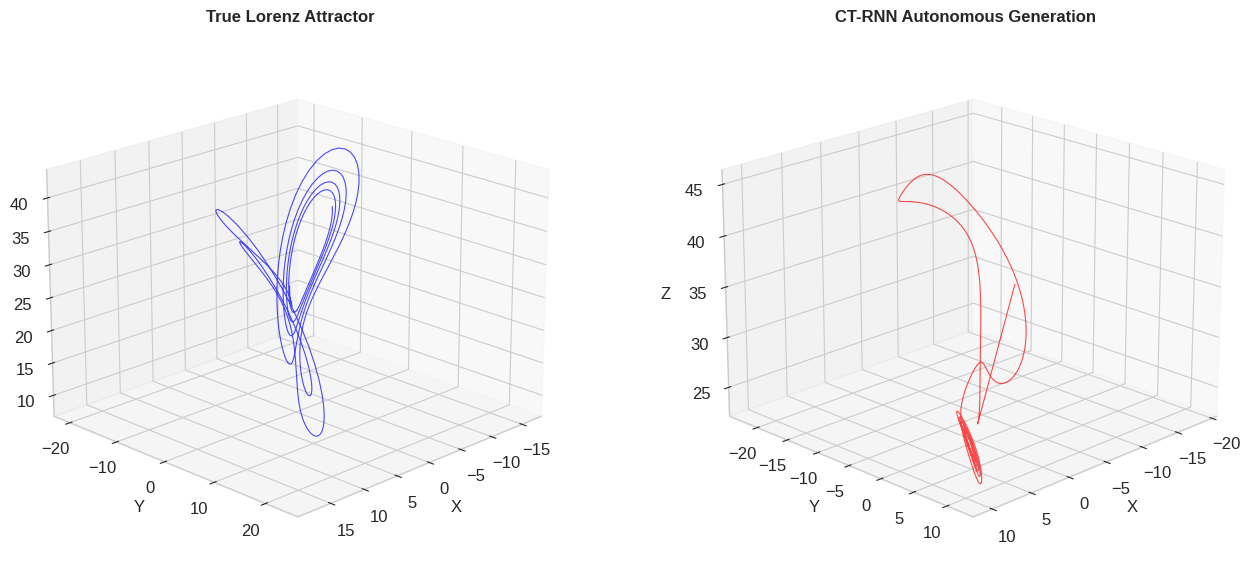


🎯 Autonomous generation shows the network can produce Lorenz-like
   dynamics, though long-term divergence is expected due to chaos!


In [ ]:
# Autonomous generation: let the network predict recursively
# Start from a test sample and let it generate freely

print("Generating autonomous trajectory...")

# Get an initial state from test set (NORMALIZED)
# Extract normalized targets from test_loader
with torch.no_grad():
    sample_x, sample_y = next(iter(test_loader))
    initial_state_norm = sample_y[0:1].to(device)  # Shape: (1, 3), normalized

print(f"Initial state (normalized): {initial_state_norm[0].cpu().numpy()}")

# Generate 500 steps autonomously
n_steps = 50000
with torch.no_grad():
    generated = model.generate(
        initial_state=initial_state_norm,
        n_steps=n_steps,
        dt=0.01
    )

generated_np = generated[0].cpu().numpy()  # (n_steps, 3)

# Denormalize
generated_denorm = generated_np * std + mean

print(f"✓ Generated {n_steps} autonomous steps")
print(f"  Shape: {generated_denorm.shape}")

# Visualize autonomous generation vs true attractor
fig = plt.figure(figsize=(14, 6))

# True Lorenz attractor
ax1 = fig.add_subplot(121, projection='3d')
n_show = min(500, len(targets_denorm))
ax1.plot(targets_denorm[:n_show, 0], targets_denorm[:n_show, 1], 
         targets_denorm[:n_show, 2], 'b-', lw=0.8, alpha=0.7)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('True Lorenz Attractor', fontsize=12, fontweight='bold')
ax1.view_init(elev=20, azim=45)

# Autonomously generated trajectory
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(generated_denorm[:, 0], generated_denorm[:, 1], generated_denorm[:, 2],
         'r-', lw=0.8, alpha=0.7)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('CT-RNN Autonomous Generation', fontsize=12, fontweight='bold')
ax2.view_init(elev=20, azim=45)

plt.tight_layout()
plt.show()


Creating model with RK4 solver for generation...
Generating with RK4 solver for 50000 steps...


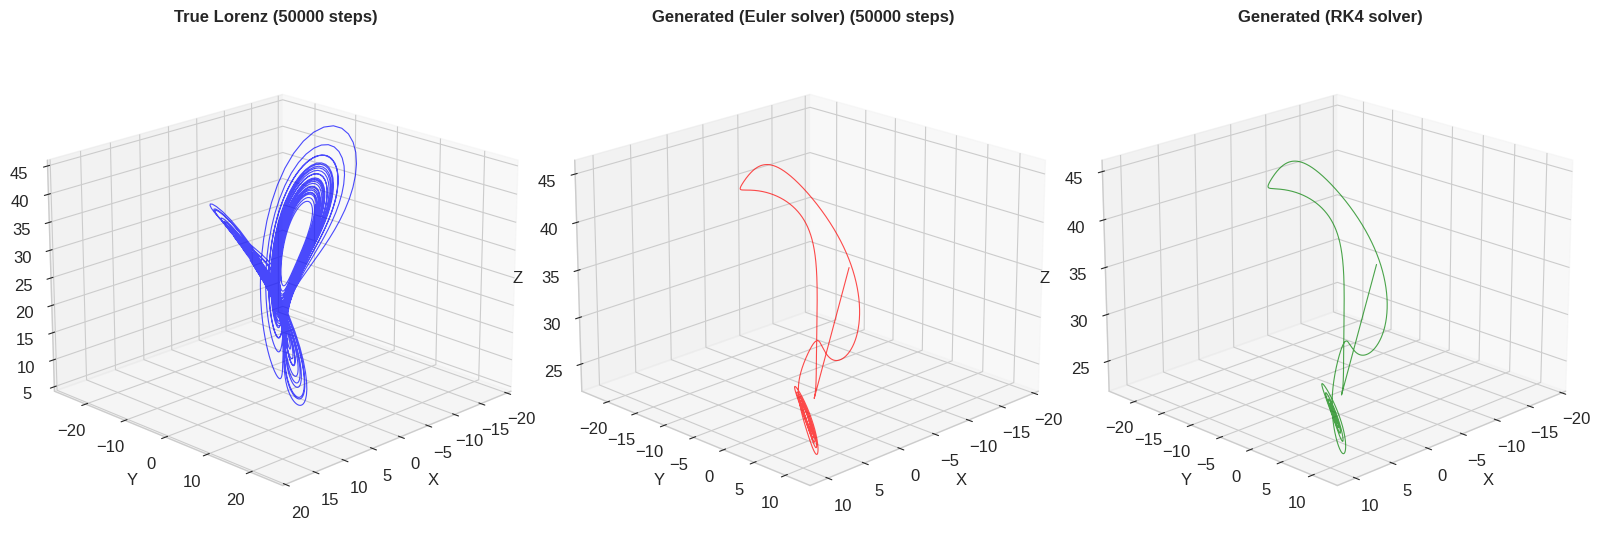


🔍 Diagnosis:
If RK4 looks better than Euler: The solver accuracy matters for generation
If both look wrong: The model may not have learned the dynamics well


In [ ]:
# Test autonomous generation with more accurate solver
# Create a temporary model with RK4 solver for comparison

print("Creating model with RK4 solver for generation...")
from src.models import ContinuousTimeRNN

# Create a model with RK4 solver (more accurate)
model_rk4 = ContinuousTimeRNN(
    input_size=3,
    hidden_size=64,
    output_size=3,
    tau=1.0,
    solver='rk4'  # More accurate than euler
).to(device)

# Load the trained weights
model_rk4.load_state_dict(torch.load('checkpoints/ctrnn_best.pt'))
model_rk4.eval()

n_steps = 50000
print(f"Generating with RK4 solver for {n_steps} steps...")

# Generate with RK4
with torch.no_grad():
    sample_x, sample_y = next(iter(test_loader))
    initial_state_norm = sample_y[0:1].to(device)
    
    # Generate 50000 steps (longer sequence)
    generated_rk4 = model_rk4.generate(
        initial_state=initial_state_norm,
        n_steps=n_steps,
        dt=0.01
    )

generated_rk4_np = generated_rk4[0].cpu().numpy()
generated_rk4_denorm = generated_rk4_np * std + mean

# Compare Euler vs RK4
fig = plt.figure(figsize=(16, 6))

# True Lorenz
ax1 = fig.add_subplot(131, projection='3d')
n_show = n_steps
ax1.plot(targets_denorm[:n_show, 0], targets_denorm[:n_show, 1], 
         targets_denorm[:n_show, 2], 'b-', lw=0.8, alpha=0.7)
ax1.set_title(f'True Lorenz ({n_steps} steps)', fontsize=12, fontweight='bold')
ax1.view_init(elev=20, azim=45)

# Euler solver
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot(generated_denorm[:n_steps, 0], generated_denorm[:n_steps, 1], 
         generated_denorm[:n_steps, 2], 'r-', lw=0.8, alpha=0.7)
ax2.set_title(f'Generated (Euler solver) ({n_steps} steps)', fontsize=12, fontweight='bold')
ax2.view_init(elev=20, azim=45)

# RK4 solver
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot(generated_rk4_denorm[:n_steps, 0], generated_rk4_denorm[:n_steps, 1], 
         generated_rk4_denorm[:n_steps, 2], 'g-', lw=0.8, alpha=0.7)
ax3.set_title(f'Generated (RK4 solver) ({n_steps} steps)', fontsize=12, fontweight='bold')
ax3.view_init(elev=20, azim=45)

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

plt.tight_layout()
plt.show()

## Summary

We implemented a **Continuous-Time RNN** using Neural ODEs and trained it on Lorenz prediction.

**Key observations:**
- CT-RNN can learn chaotic dynamics
- One-step prediction is highly accurate
- Long-term autonomous prediction diverges (expected due to chaos!)
- The generated attractor has similar geometry to the true one

**Next:** Notebook 02 - Balanced E/I Rate Network